In [1]:
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K


In [2]:
print("Using Tensorflow {}".format(tf.__version__))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("{} GPUs found".format(len(physical_devices)))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Using {}".format(physical_devices[0]))


Using Tensorflow 2.1.0
1 GPUs found
Using PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
tf.random.set_seed(1234)

TESTING = False


In [4]:

# Network hyperparameters from arXiv:1903.02433

# Training
BATCH_SIZE = 128 # 128 in paper
EPOCHS = 30 # 500000 in paper, but on much smaller dataset
PRETRAIN_EPOCHS = 20

# Adam hyperparameters
LEARNING_RATE = 1e-5 # TODO: Learning rate scheduler
BETA_1 = 0.5
BETA_2 = 0.9

# SGD hyperparameters
SGD_LEARNING_RATE = 0.01

# Architecture
NOISE_DIM = 128 # 64 in Gitlab

# Plotting
PREFIX = "img/{:.0f}D-{}batchsize-".format(NOISE_DIM, BATCH_SIZE)
DRAW_INTERVAL = 10
BINS = 25
if TESTING:
    SAMPLE_SIZE = 2000
else:
    SAMPLE_SIZE = 20000

In [5]:


filenames = {
    "herwig": "events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [6]:

def load_data(datatype, stop = None, rotate = True, flip_eta = True):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = pd.DataFrame(dtype = "float32")

    for jet in ["j1", "j2"]:
        output_frame["pt" + jet] = np.sqrt(input_frame["px" + jet]**2 + input_frame["py" + jet]**2)
        output_frame["eta" + jet] = np.arcsinh(input_frame["pz" + jet] / output_frame["pt" + jet])
        output_frame["phi" + jet] = np.arctan2(input_frame["py" + jet], input_frame["px" + jet])
        output_frame["m" + jet] = input_frame["m" + jet]
        output_frame["p" + jet] = np.sqrt(input_frame["pz" + jet]**2 + output_frame["pt" + jet]**2)
        output_frame["e" + jet] = np.sqrt(output_frame["m" + jet]**2 + output_frame["p" + jet]**2)
        output_frame["tau21" + jet] = input_frame["tau2" + jet] / input_frame["tau1" + jet]
        output_frame["tau32" + jet] = input_frame["tau3" + jet] / input_frame["tau2" + jet]
    
    del input_frame
    gc.collect()

    # Not exact rotation, since negative angles for phi2 are flipped across the x-axis. Should be OK due to symmetry.
    if rotate:
        output_frame["phij2"] = np.abs(output_frame["phij2"] - output_frame["phij1"])
        output_frame["phij1"] = 0
    
    if flip_eta:
        flipped_frame = output_frame.copy()
        flipped_frame["etaj1"] *= -1
        flipped_frame["etaj2"] *= -1
        output_frame = output_frame.append(flipped_frame)
        del flipped_frame
        gc.collect()
    
    for jet in ["j1", "j2"]:
        output_frame["px" + jet] = output_frame["pt" + jet] * np.cos(output_frame["phi" + jet])
        output_frame["py" + jet] = output_frame["pt" + jet] * np.sin(output_frame["phi" + jet])
        output_frame["pz" + jet] = output_frame["pt" + jet] * np.sinh(output_frame["eta" + jet])
    
    # Dijet properties
    output_frame["pxjj"] = output_frame["pxj1"] + output_frame["pxj2"]
    output_frame["pyjj"] = output_frame["pyj1"] + output_frame["pyj2"]
    output_frame["pzjj"] = output_frame["pzj1"] + output_frame["pzj2"]
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt(output_frame["pxjj"]**2 + output_frame["pyjj"]**2 + output_frame["pzjj"]**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)

    # NaNs may arise from overly sparse jets with tau1 = 0, tau2 = 0, etc.
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)
    
    return output_frame.astype('float32')

In [7]:

if TESTING:
    df_bg = load_data("pythiabg", stop = 10000)
    df_sig = load_data("pythiasig", stop = 1000)
else:
    df_bg = load_data("pythiabg")
    df_sig = load_data("pythiasig")

df_bg_SB = df_bg[(df_bg["mjj"] < 3300) | (df_bg["mjj"] > 3700)]
df_bg_SR = df_bg[(df_bg["mjj"] >= 3300) & (df_bg["mjj"] <= 3700)]

df_sig_SB = df_sig[(df_sig["mjj"] < 3300) | (df_sig["mjj"] > 3700)] # This should pretty much be empty
df_sig_SR = df_sig[(df_sig["mjj"] >= 3300) & (df_sig["mjj"] <= 3700)]

df_bg_SB.reset_index(drop = True, inplace = True)
df_bg_SR.reset_index(drop = True, inplace = True)
df_sig_SB.reset_index(drop = True, inplace = True)
df_sig_SR.reset_index(drop = True, inplace = True)

print("df_bg shape {}".format(df_bg.shape))
print("df_sig shape {}".format(df_sig.shape))
print("df_bg_SB shape {}".format(df_bg_SB.shape))
print("df_bg_SR shape {}".format(df_bg_SR.shape))
print("df_sig_SB shape {}".format(df_sig_SB.shape))
print("df_sig_SR shape {}".format(df_sig_SR.shape))
print()

df_bg shape (1999760, 28)
df_sig shape (199930, 28)
df_bg_SB shape (1757082, 28)
df_bg_SR shape (242678, 28)
df_sig_SB shape (49334, 28)
df_sig_SR shape (150596, 28)



In [8]:

def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]


In [9]:
np_bg_SB = cut_data(np.array(df_bg_SB[features]))
np_bg_SR = cut_data(np.array(df_bg_SR[features]))
np_sig_SR = cut_data(np.array(df_sig_SR[features]))
np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
del df_bg_SB
del df_bg_SR
del df_sig_SB
del df_sig_SR
gc.collect()

# Ensures all training batches have same size
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

X_train, X_test = train_test_split(np_bg_SB_scaled, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

Dataset consists of 10293 batches of 128 samples each, total 1317504 samples
Testset consists of 3431 batches of 128 samples each, total 439168 samples


In [10]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = (GEN_DIM,)))
    model.add(layers.Dense(128, kernel_initializer = 'glorot_uniform'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2DTranspose(32, kernel_size = 2, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(len(train_features), activation = 'tanh'))

    return model


In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = (DISC_DIM,)))
    model.add(layers.Dense(128))    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2D(64, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Flatten())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model


In [12]:
generator = make_generator_model()
generator.summary()
print()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16640     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          1

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()
print()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               1408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          1216      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)         

In [14]:
mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [15]:
@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
@tf.function
def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

In [17]:
# Paper optimizer:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

#generator_optimizer = tf.keras.optimizers.Adam(SGD_LEARNING_RATE)
#discriminator_optimizer = tf.keras.optimizers.Adam(SGD_LEARNING_RATE)


In [18]:
# Convert tensor to float for loss function plotting
# (Random code from StackOverflow) - don't really know what does, but it works
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]


In [19]:
@tf.function
def train_step_generator(labels):
  labels_rescaled = labels * 2 - 1

  gen_input = tf.concat([tf.random.uniform([BATCH_SIZE, NOISE_DIM]), labels], 1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=True)
    fake_output = discriminator(tf.concat([generated_vector, labels_rescaled], 1), training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss


In [20]:
@tf.function
def train_step_discriminator(vectors, labels):
  labels_rescaled = labels * 2 - 1
  gen_input = tf.concat([tf.random.uniform([BATCH_SIZE, NOISE_DIM]), labels], 1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=True)

    real_output = discriminator(tf.concat([vectors, labels_rescaled], 1), training=True)
    fake_output = discriminator(tf.concat([generated_vector, labels_rescaled], 1), training=True)
    
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [21]:
@tf.function
def evaluate_generator(labels):
  labels_rescaled = labels * 2 - 1
  gen_input = tf.concat([tf.random.uniform([BATCH_SIZE, NOISE_DIM]), labels], 1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=False)
    fake_output = discriminator(tf.concat([generated_vector, labels_rescaled], 1), training=False)
    gen_loss = generator_loss(fake_output)
  
  return gen_loss


In [22]:
@tf.function
def evaluate_discriminator(vectors, labels):
  labels_rescaled = labels * 2 - 1
  gen_input = tf.concat([tf.random.uniform([BATCH_SIZE, NOISE_DIM]), labels], 1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=False)

    real_output = discriminator(tf.concat([vectors, labels_rescaled], 1), training=False)
    fake_output = discriminator(tf.concat([generated_vector, labels_rescaled], 1), training=False)
    
    disc_loss = discriminator_loss(real_output, fake_output)
  
  return disc_loss

In [23]:
def sample_labels(refdata = np_bg_SB, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))

In [24]:
def graph_gan(generator, epoch, mode = "bg_SB"):
    plt.close()

    if mode == "bg_SB":
        realdata = np_bg_SB
        label = "Background Sideband"
        ganlabel = "GAN"
        title = "Background SB Generation (Normalized to Unity)"
    elif mode == "bg_SR":
        realdata = np_bg_SR
        label = "Background Signal Region"
        ganlabel = "GAN Interpolation"
        title = "Background SR Interpolation (Normalized to Unity)"
    elif mode == "sig_SR":
        realdata = np_sig_SR
        label = "BSM Signal"
        ganlabel = "GAN Interpolation"
        title = "BSM Signal Interpolation (Normalized to Unity)"
    elif mode == "combined_SR":
        realdata = np_combined_SR
        label = "Mixed Signal Region"
        ganlabel = "GAN Interpolation"
        title = "Mixed Data SR Interpolation (Normalized to Unity)"
    else:
        raise ValueError("Unexpected mode {} in graph_gan()".format(mode))

    labels = sample_labels(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    
    f, a = plt.subplots(3, 3, constrained_layout=True)

    f.suptitle(title)

    a[0, 0].set_title("Leading jet pT")
    a[0, 0].set_xlabel("$pT_{J_1}$")
    a[0, 0].hist(realdata[:,0], bins = BINS, range = (1200, 2000), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 0].hist(fakedata[:,0], bins = BINS, range = (1200, 2000), color = "tab:blue", histtype = "step", label = ganlabel, density = True)

    a[0, 1].set_title("Leading jet eta")
    a[0, 1].set_xlabel("$\\eta_{J_1}$")
    a[0, 1].hist(realdata[:,1], bins = BINS, range = (0, 2.5), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 1].hist(fakedata[:,1], bins = BINS, range = (0, 2.5), color = "tab:blue", histtype = "step", label = ganlabel, density = True)

    a[0, 2].set_title("Leading jet mass")
    a[0, 2].set_xlabel("$m_{J_1}$")
    a[0, 2].hist(realdata[:,2], bins = BINS, range = (0, 750), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 2].hist(fakedata[:,2], bins = BINS, range = (0, 750), color = "tab:blue", histtype = "step", label = ganlabel, density = True)
    
    a[1, 0].set_title("Subleading jet pT")
    a[1, 0].set_xlabel("$pT_{J_2}$")
    a[1, 0].hist(realdata[:,3], bins = BINS, range = (500, 2000), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 0].hist(fakedata[:,3], bins = BINS, range = (500, 2000), color = "tab:blue", histtype = "step", label = ganlabel, density = True)

    a[1, 1].set_title("Subleading jet eta")
    a[1, 1].set_xlabel("$\\eta_{J_2}$")
    a[1, 1].hist(realdata[:,4], bins = BINS, range = (0, 2.5), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 1].hist(fakedata[:,4], bins = BINS, range = (0, 2.5), color = "tab:blue", histtype = "step", label = ganlabel, density = True)

    a[1, 2].set_title("Subleading jet mass")
    a[1, 2].set_xlabel("$m_{21J_2}$")
    a[1, 2].hist(realdata[:,6], bins = BINS, range = (0, 750), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 2].hist(fakedata[:,6], bins = BINS, range = (0, 750), color = "tab:blue", histtype = "step", label = ganlabel, density = True)
    
    a[2, 0].set_title("Leading jet tau21")
    a[2, 0].set_xlabel("$\\tau_{21J_1}$")
    a[2, 0].hist(realdata[:,7], bins = BINS, range = (0, 1), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[2, 0].hist(fakedata[:,7], bins = BINS, range = (0, 1), color = "tab:blue", histtype = "step", label = ganlabel, density = True)

    a[2, 1].set_title("Subleading jet tau21")
    a[2, 1].set_xlabel("$\\tau_{21J_2}$")
    a[2, 1].hist(realdata[:,8], bins = BINS, range = (0, 1), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[2, 1].hist(fakedata[:,8], bins = BINS, range = (0, 1), color = "tab:blue", histtype = "step", label = ganlabel, density = True)

    a[2, 2].set_title("Dijet mass")
    a[2, 2].set_xlabel("$m_{JJ}$")
    a[2, 2].hist(realdata[:,9], bins = BINS, range = (1500, 5500), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[2, 2].hist(fakedata[:,9], bins = BINS, range = (1500, 5500), color = "tab:blue", histtype = "step", label = ganlabel, density = True)
    # a[2, 2].legend(loc="right") # Too cramped

    if TESTING:
        plt.show()
    else:
        plt.show()


In [25]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []


In [26]:
def graph_losses(epoch):
    plt.close()

    f, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)

    f.suptitle("Loss Functions")

    ax1.set_title("Generator Loss")
    ax1.set_ylabel("Mean-Square Error")
    ax1.plot(train_gen_losses, 'b', label = "Training loss")
    ax1.plot(test_gen_losses, 'r', label = "Validation loss")
    ax1.legend(loc="upper right")

    ax2.set_title("Discriminator Loss")
    ax2.set_ylabel("Binary Cross-Entropy")
    ax2.set_xlabel("Epoch")
    ax2.plot(train_disc_losses, 'b', label = "Training loss")
    ax2.plot(test_disc_losses, 'r', label = "Validation loss")

    if TESTING:
        plt.show()
    else:
        plt.show()

# TODO: Pre-train discriminator

In [27]:
def train(dataset, testset, epochs, pretrain = False):
    for epoch in tqdm(range(epochs)):
        print_losses = False #((epoch + 1) % 10 == 0)

        if pretrain:
            draw_outputs = False
        else:
            draw_outputs = ((epoch + 1) % DRAW_INTERVAL == 0)

        train_gen_loss = 0
        train_disc_loss = 0

        test_gen_loss = 0
        test_disc_loss = 0

        # Training

        for batchnum, image_batch in enumerate(dataset):
            vectors = image_batch[:,:-1]
            labels = tf.reshape(image_batch[:,-1], (BATCH_SIZE,1))
            if pretrain:
                train_step_discriminator(vectors, labels)
            else:
                train_disc_loss += K_eval(train_step_discriminator(vectors, labels)) / len_dataset
                train_gen_loss += K_eval(train_step_generator(tf.constant(scaler_mjj.transform(sample_labels()), dtype = tf.float32))) / len_dataset

        if not pretrain:
            train_gen_losses.append(train_gen_loss)
            train_disc_losses.append(train_disc_loss)

        # Evaluation
        if not pretrain:
            for batchnum, test_batch in enumerate(testset):
                vectors = test_batch[:,:-1]
                labels = tf.reshape(test_batch[:,-1], (BATCH_SIZE,1))
                test_gen_loss += K_eval(evaluate_generator(tf.constant(scaler_mjj.transform(sample_labels()), dtype = tf.float32))) / len_testset
                test_disc_loss += K_eval(evaluate_discriminator(vectors, labels)) / len_testset

        if not pretrain:
            test_gen_losses.append(test_gen_loss)
            test_disc_losses.append(test_disc_loss)

        # Logging

        if print_losses:
            print()
            print("Epoch " + str(epoch + 1) + ":")
            print()
            print("Generator training loss: " + str(train_gen_losses[-1]))
            print("Discriminator training loss: " + str(train_disc_losses[-1]))
            print()
            print("Generator validation loss: " + str(test_gen_losses[-1]))
            print("Discriminator validation loss: " + str(test_disc_losses[-1]))

        if draw_outputs:
            print()
            print("Epoch " + str(epoch + 1) + ":")
            graph_gan(generator, epoch + 1, mode = "bg_SB")
            graph_gan(generator, epoch + 1, mode = "bg_SR")
            graph_gan(generator, epoch + 1, mode = "sig_SR")
            graph_gan(generator, epoch + 1, mode = "combined_SR")
            graph_losses(epoch + 1)

In [28]:
print("Now pre-training discriminator for {} epochs".format(PRETRAIN_EPOCHS))
train(train_dataset, test_dataset, PRETRAIN_EPOCHS, pretrain = True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Now pre-training discriminator for 20 epochs
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [17:15<00:00, 51.80s/it]


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Now training model for 30 epochs
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VE

 30%|████████████████████████▌                                                         | 9/30 [16:20<37:10, 106.23s/it]


Epoch 10:


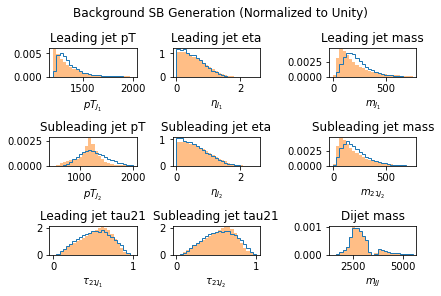

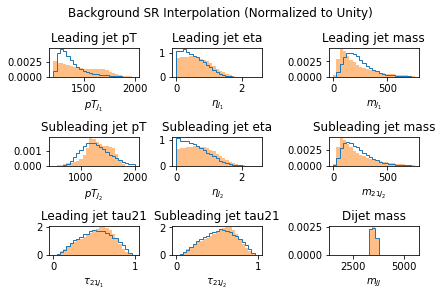

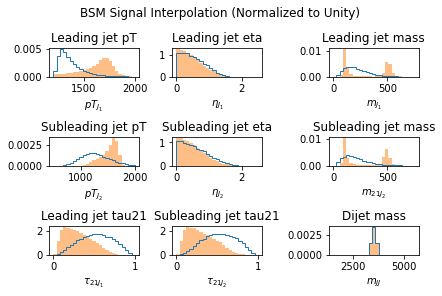

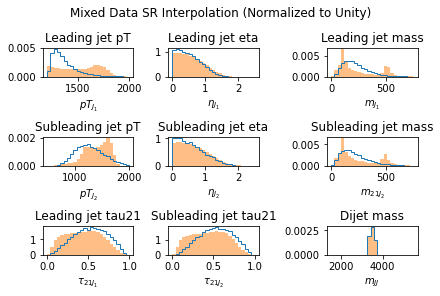

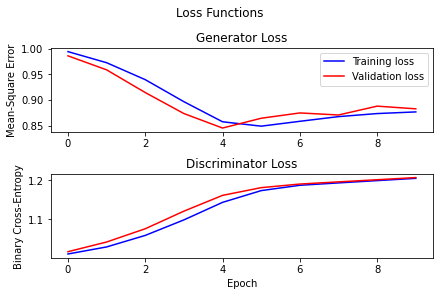

 63%|███████████████████████████████████████████████████▉                              | 19/30 [29:56<15:00, 81.88s/it]


Epoch 20:


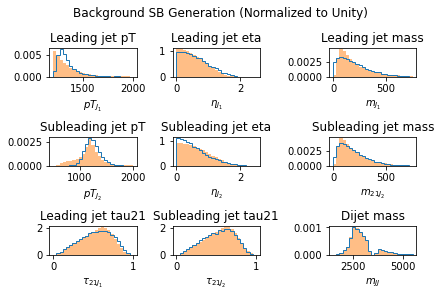

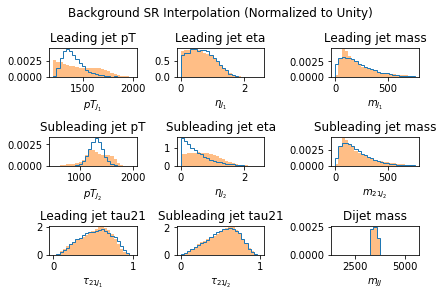

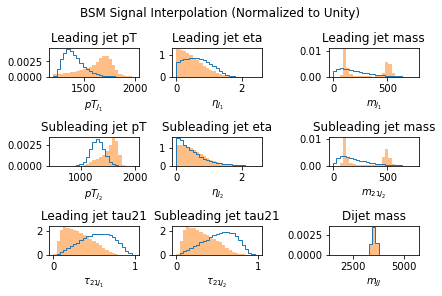

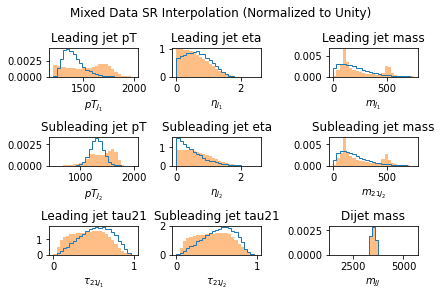

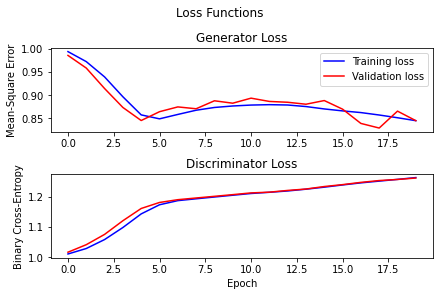

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [43:33<01:20, 80.91s/it]


Epoch 30:


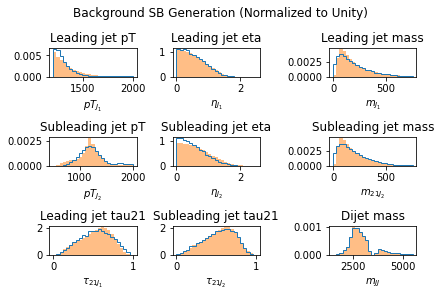

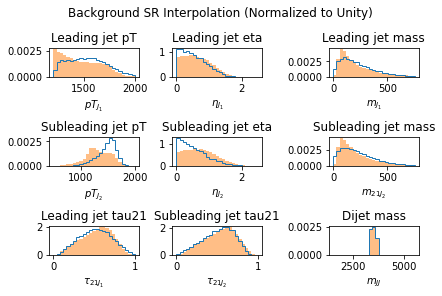

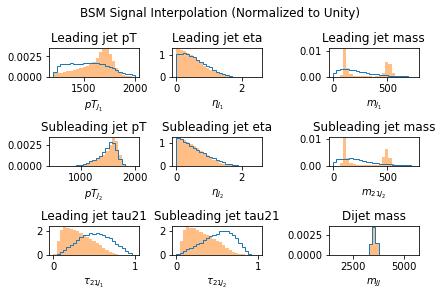

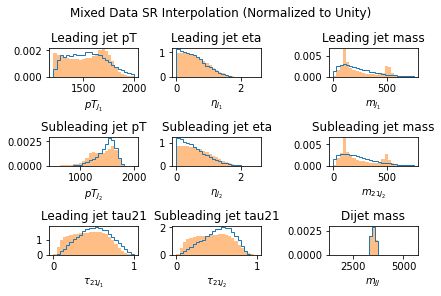

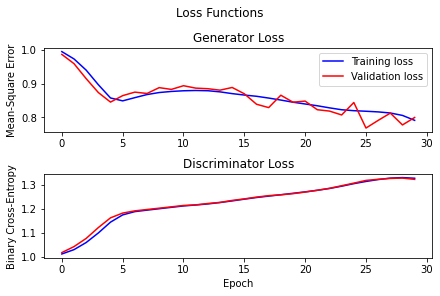

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [45:02<00:00, 90.08s/it]


In [29]:
print("Now training model for {} epochs".format(EPOCHS))
train(train_dataset, test_dataset, EPOCHS, pretrain = False)